# **Telecom churn prediction**



In the highly competitive telecommunications industry, customer churn—the loss of subscribers to competitors—poses a major challenge. With numerous options and constantly evolving customer preferences, retaining existing customers is crucial for business sustainability. This project leverages Supervised Machine Learning (classification) to develop a predictive model that helps businesses identify at-risk customers and implement proactive retention strategies.

The project follows a structured approach, beginning with data preprocessing to handle missing values, convert categorical variables, and ensure a clean dataset. By conducting Exploratory Data Analysis (EDA), key patterns and trends in customer behavior are uncovered, providing deeper insights into the factors influencing churn.

To build an effective prediction model, various machine learning algorithms, such as Logistic Regression, Decision Trees, and Random Forests, are implemented and fine-tuned for optimal performance. These models analyze historical customer data, evaluating attributes like contract type, monthly charges, and tenure to determine the likelihood of churn.

The performance of the models is assessed using key evaluation metrics, including accuracy, precision, recall, and F1-score, ensuring a reliable and actionable prediction system. The insights generated from this analysis enable businesses to develop personalized offers, targeted marketing campaigns, and improved customer support to reduce churn rates.

By leveraging data-driven decision-making, this project empowers telecommunications companies to enhance customer satisfaction, foster long-term loyalty, and maintain a competitive edge in the market.



### **Dataset Information**  
The original dataset, **Telco-Customer-Churn**, is divided into three parts:  
- **Part 1:** 3000 records  
- **Part 2:** 2000 records  
- **Part 3:** 2000 records  


In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import openpyxl
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.colors as colors
from plotly.subplots import make_subplots
from statsmodels.genmod.families import Binomial
from scipy.stats import pointbiserialr
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mutual_info_score
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

## **Data Preparation**


### Clean First Dataset

In [3]:
data = pd.read_csv('/content/part1 3000.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [4]:
del data["customerID"]

In [5]:
bool_to_obj = {'Partner': object,
               'SeniorCitizen': object,
               'Dependents': object,
               'PhoneService': object,
               'PaperlessBilling': object}

data = data.astype(bool_to_obj)

In [6]:
replace_values = {True: 'Yes', False: 'No'}


data['Partner'] = data['Partner'].replace(replace_values)
data['SeniorCitizen'] = data['SeniorCitizen'].replace(replace_values)
data['Dependents'] = data['Dependents'].replace(replace_values)
data['PhoneService'] = data['PhoneService'].replace(replace_values)
data['MultipleLines'] = data['MultipleLines'].replace(replace_values)
data['OnlineSecurity'] = data['OnlineSecurity'].replace(replace_values)
data['OnlineBackup'] = data['OnlineBackup'].replace(replace_values)
data['DeviceProtection'] = data['DeviceProtection'].replace(replace_values)
data['TechSupport'] = data['TechSupport'].replace(replace_values)
data['StreamingTV'] = data['StreamingTV'].replace(replace_values)
data['StreamingMovies'] = data['StreamingMovies'].replace(replace_values)
data['PaperlessBilling'] = data['PaperlessBilling'].replace(replace_values)
data['Churn'] = data['Churn'].replace(replace_values)

In [7]:
data['Churn'].unique()

array(['No', 'Yes', nan], dtype=object)

In [8]:
data['Churn'].isna().sum()

np.int64(1)

In [9]:
data.dropna(subset='Churn', inplace=True)

In [10]:
data.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,269
InternetService,0
OnlineSecurity,651
OnlineBackup,651


In [11]:
data[np.isnan(data['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,No,Yes,Yes,0,No,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.549999,NaN,No
753,Male,No,No,Yes,0,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Mailed check,20.250000,NaN,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.849998,NaN,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Mailed check,25.750000,NaN,No
1340,Female,No,Yes,Yes,0,No,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.049999,NaN,No


In [12]:
data.drop(labels=data[data['tenure'] == 0].index, axis=0, inplace=True)

In [13]:
columns_to_replace = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies']

for column in columns_to_replace:
    data[column].fillna(data[column].mode()[0], inplace=True)

### **Clean Third Dataset**

In [14]:
data3 = pd.read_csv('/content/part 3 2000.csv')

In [15]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [16]:
data3.drop(columns='customerID', inplace=True)

In [17]:
data3['TotalCharges'] = pd.to_numeric(data3['TotalCharges'], errors='coerce')
data3.isna().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [18]:
data3[np.isnan(data3['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
1670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
1754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


In [19]:
data3.drop(labels=data3[data3['tenure'] == 0].index, axis=0, inplace=True)
data3['SeniorCitizen'].value_counts()

,count
SeniorCitizen,
0,1696
1,344


In [20]:
data3['SeniorCitizen'] = data3['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
data3['SeniorCitizen'] = data3['SeniorCitizen'].astype('object')

## **Combine and prepare the final training dataset.**

In [21]:
Data_All= pd.concat([data, data3], ignore_index=True)
Data_All.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5034 non-null   object 
 1   SeniorCitizen     5034 non-null   object 
 2   Partner           5034 non-null   object 
 3   Dependents        5034 non-null   object 
 4   tenure            5034 non-null   int64  
 5   PhoneService      5034 non-null   object 
 6   MultipleLines     5034 non-null   object 
 7   InternetService   5034 non-null   object 
 8   OnlineSecurity    5034 non-null   object 
 9   OnlineBackup      5034 non-null   object 
 10  DeviceProtection  5034 non-null   object 
 11  TechSupport       5034 non-null   object 
 12  StreamingTV       5034 non-null   object 
 13  StreamingMovies   5034 non-null   object 
 14  Contract          5034 non-null   object 
 15  PaperlessBilling  5034 non-null   object 
 16  PaymentMethod     5034 non-null   object 


In [22]:
Data_All.describe(include=['object']).T

,count,unique,top,freq
gender,5034,2,Male,2554
SeniorCitizen,5034,2,No,4215
Partner,5034,2,No,2583
Dependents,5034,2,No,3481
PhoneService,5034,2,Yes,4547
MultipleLines,5034,3,No,2688
InternetService,5034,3,Fiber optic,2247
OnlineSecurity,5034,3,No,3155
OnlineBackup,5034,3,No,2879
DeviceProtection,5034,3,No,2867


In [23]:
Data_All.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,5034.0,32.620580,24.511015,1.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5034.0,65.107251,30.068019,18.400000,35.799999,70.599998,90.050003,118.650002
TotalCharges,5034.0,2300.954758,2268.346402,18.799999,417.662498,1401.000000,3860.599976,8670.100000


In [24]:
print('Known observations: {}\nUnique observations: {}'.format(len(Data_All.index),len(Data_All.drop_duplicates().index)))

Known observations: 5034
Unique observations: 5024


In [25]:
for column in Data_All.columns:
    print('Column: {} - Unique Values: {}'.format(column, Data_All[column].unique()))

Column: gender - Unique Values: ['Female' 'Male']
Column: SeniorCitizen - Unique Values: ['No' 'Yes']
Column: Partner - Unique Values: ['Yes' 'No']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: tenure - Unique Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Column: PhoneService - Unique Values: ['No' 'Yes']
Column: MultipleLines - Unique Values: ['No' 'Yes' 'No phone service']
Column: InternetService - Unique Values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values: ['No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique Values: ['Yes' 'No' 'No internet service']
Column: DeviceProtection - Unique Values: ['No' 'Yes' 'No internet service']
Column: TechSupport - Unique Values: ['No' 'Yes' 'No internet service']
Column: StreamingTV - Unique Values: ['No' 'Yes' 'No internet se

In [26]:
Data_All.isna().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


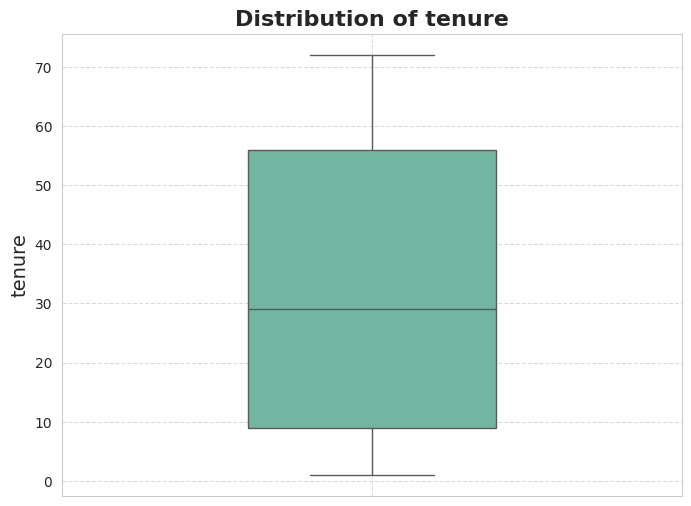

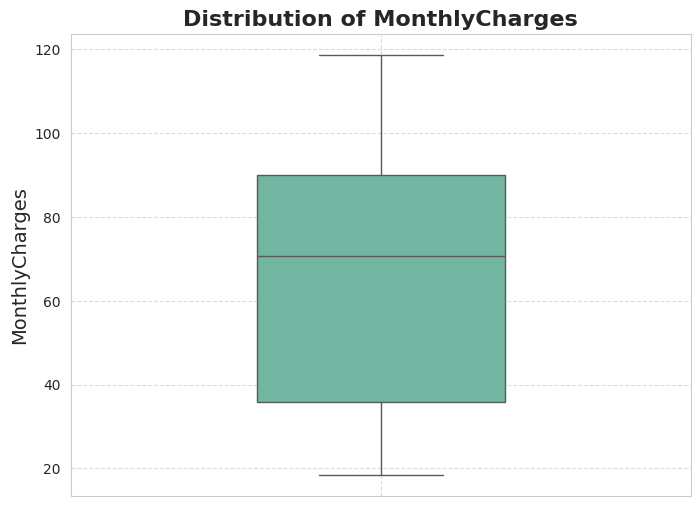

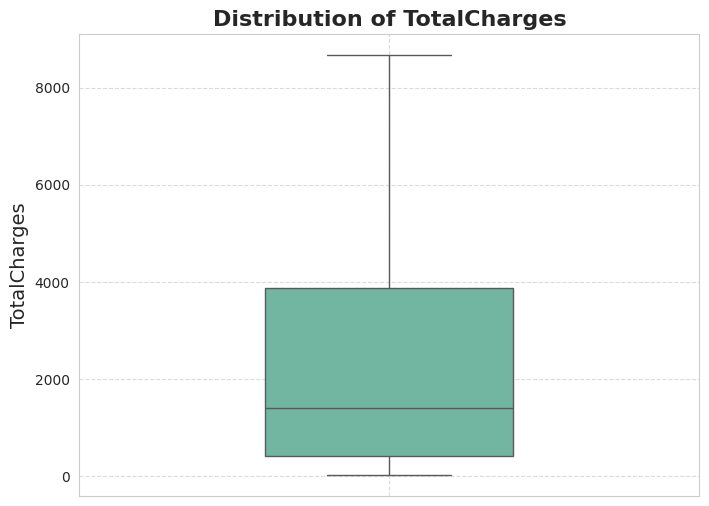

In [27]:
import seaborn as sns
for col in ['tenure','MonthlyCharges','TotalCharges']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=Data_All[col], palette="Set2", width=0.4)

    plt.title(f'Distribution of {col}', fontsize=16, fontweight='bold')
    plt.ylabel(col, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

### Normality Testing

In [28]:
stat, p = stats.normaltest(Data_All['MonthlyCharges'])
print('Statistics=%.5f, p=%.3f' % (stat, p))
alpha = 0.05

if p > alpha:
    print('the sample is normally distributed')
else:
    print('the sample is skewed')

Statistics=7510.47646, p=0.000
the sample is skewed


In [29]:
stat, p = stats.normaltest(Data_All['tenure'])
print('Statistics=%.5f, p=%.3f' % (stat, p))
alpha = 0.05

if p > alpha:
    print('the sample is normally distributed')
else:
    print('the sample is skewed')
alpha = 0.05

if p > alpha:
	print('the sample is normally distributed')
else:
	print('the sample is skewed')

Statistics=53555.33858, p=0.000
the sample is skewed
the sample is skewed


In [30]:
stat, p = stats.normaltest(Data_All['TotalCharges'])
print('Statistics=%.5f, p=%.3f' % (stat, p))

alpha = 0.05

if p > alpha:
	print('the sample is normally distributed')
else:
	print('the sample is skewed')

Statistics=569.05463, p=0.000
the sample is skewed


In [31]:
Data_All.reset_index(drop=True, inplace=True)
Data_All.to_csv('Train_Data.csv', index=False)

In [32]:
print("**Data Types**")
Data_All.dtypes.value_counts()

**Data Types**


,count
object,17
float64,2
int64,1


### **Clean test data**

In [33]:
data_test = pd.read_csv('/content/part2 2000.csv')

In [34]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [35]:
data_test['TotalCharges'] = pd.to_numeric(data_test['TotalCharges'], errors='coerce')

data_test[np.isnan(data_test['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN
826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
1380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN


In [36]:
data_test.drop(labels=data_test[data_test['tenure'] == 0].index, axis=0, inplace=True)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        1997 non-null   object 
 1   gender            1997 non-null   object 
 2   SeniorCitizen     1997 non-null   int64  
 3   Partner           1997 non-null   object 
 4   Dependents        1997 non-null   object 
 5   tenure            1997 non-null   int64  
 6   PhoneService      1997 non-null   object 
 7   MultipleLines     1997 non-null   object 
 8   InternetService   1997 non-null   object 
 9   OnlineSecurity    1997 non-null   object 
 10  OnlineBackup      1997 non-null   object 
 11  DeviceProtection  1997 non-null   object 
 12  TechSupport       1997 non-null   object 
 13  StreamingTV       1997 non-null   object 
 14  StreamingMovies   1997 non-null   object 
 15  Contract          1997 non-null   object 
 16  PaperlessBilling  1997 non-null   object 
 17  

In [37]:
data_test.reset_index(drop=True, inplace=True)
data_test.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [38]:
data_test['SeniorCitizen'].dtypes
data_test['SeniorCitizen'] = data_test['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
data_test['SeniorCitizen'] = data_test['SeniorCitizen'].astype('object')

In [39]:
for column in data_test.columns:
    print('Column: {} - Unique Values: {}'.format(column, data_test[column].unique()))

Column: customerID - Unique Values: ['7613-LLQFO' '4568-TTZRT' '9513-DXHDA' ... '4816-JBHOV' '8920-NAVAY'
 '1699-TLDLZ']
Column: gender - Unique Values: ['Male' 'Female']
Column: SeniorCitizen - Unique Values: ['No' 'Yes']
Column: Partner - Unique Values: ['No' 'Yes']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: tenure - Unique Values: [12  9 27  1 24 14 32 11 38 54 29 44 59  3 18 67 22 33  5  2 72 16  8 23
 50 17 68 25 71 46 48 61 37 65 49 64 21 10  6 51 47 52 35 45  4 60 28 39
 30 55 58 26 43 56 36 13 70 69 41 15 19 31 34 66 40  7 53 63 42 57 62 20]
Column: PhoneService - Unique Values: ['Yes' 'No']
Column: MultipleLines - Unique Values: ['Yes' 'No' 'No phone service']
Column: InternetService - Unique Values: ['Fiber optic' 'No' 'DSL']
Column: OnlineSecurity - Unique Values: ['No' 'No internet service' 'Yes']
Column: OnlineBackup - Unique Values: ['No' 'No internet service' 'Yes']
Column: DeviceProtection - Unique Values: ['No' 'No internet service' 'Yes']
Column: TechSup

In [40]:
data_test.to_csv('Test_Data.csv', index=False)

### **Hypothesis Testing**

In [41]:
df_hypo = Data_All.copy()
df_hypo['Churn'] = df_hypo['Churn'].replace({'No': 0, 'Yes': 1})
correlation_coefficient, p_value = stats.pointbiserialr(df_hypo['Churn'], df_hypo['tenure'])
print(f"Point-Biserial Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05

if p_value < alpha:
    print("There is a significant correlation between customer tenure and churn rate.")
else:
    print("There is no significant correlation between customer tenure and churn rate.")

Point-Biserial Correlation Coefficient: -0.3526
P-value: 0.0000
There is a significant correlation between customer tenure and churn rate.


## **Exploratory Data Analysis(EDA)**

In [42]:
churn_data = Data_All['Churn'].value_counts()
churn_data

,count
Churn,
No,3698
Yes,1336


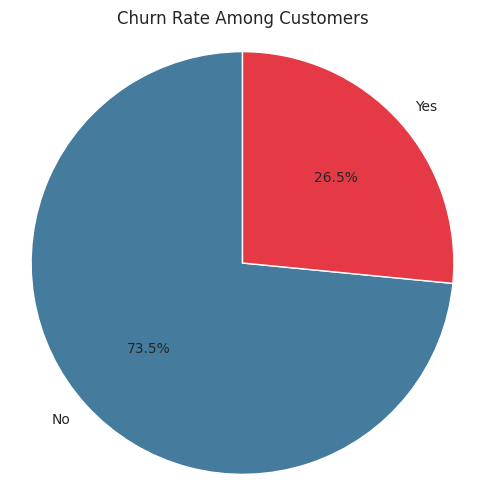

In [43]:

churn_data = Data_All['Churn'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    churn_data,
    labels=churn_data.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#457B9D', '#E63946']
)
plt.title('Churn Rate Among Customers')
plt.axis('equal')
plt.show()

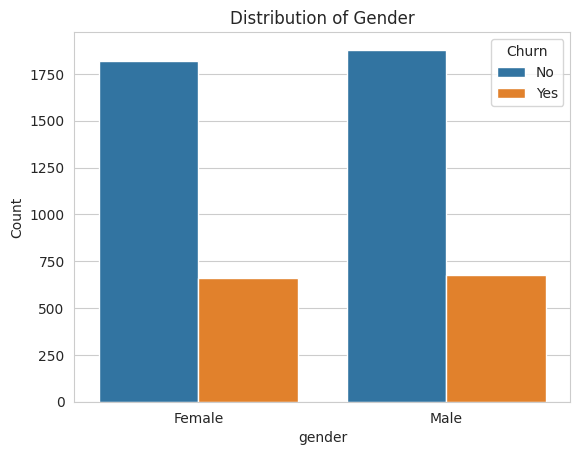

In [44]:
sns.countplot(x='gender',data=Data_All,hue='Churn')
plt.title('Distribution of Gender')
plt.xlabel('gender')
plt.ylabel('Count')
plt.show()

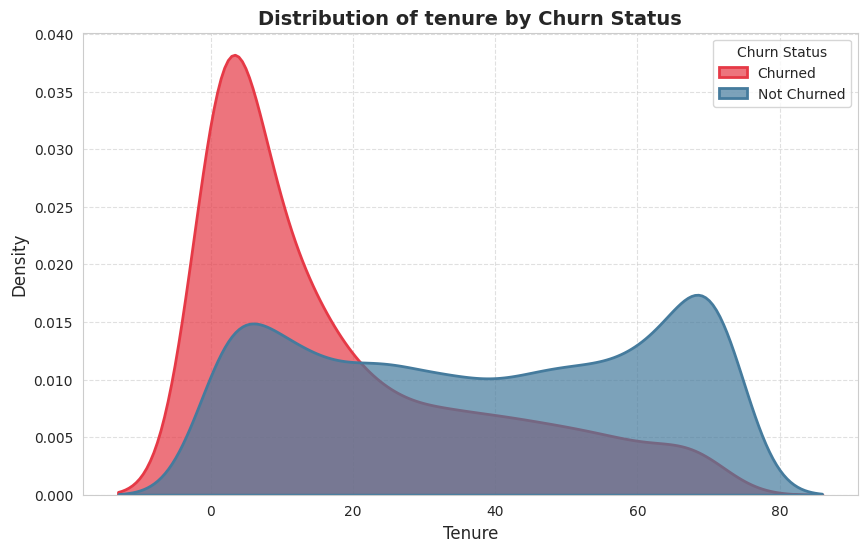

In [45]:
def kdeplot(x):
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.kdeplot(Data_All[Data_All['Churn'] == 'Yes'][x],
                color='#E63946', label='Churned', fill=True, alpha=0.7, linewidth=2)
    sns.kdeplot(Data_All[Data_All['Churn'] == 'No'][x],
                color='#457B9D', label='Not Churned', fill=True, alpha=0.7, linewidth=2)
    plt.title(f'Distribution of {x} by Churn Status', fontsize=14, fontweight='bold')
    plt.xlabel(x.capitalize(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title="Churn Status", loc='upper right')
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
kdeplot('tenure')

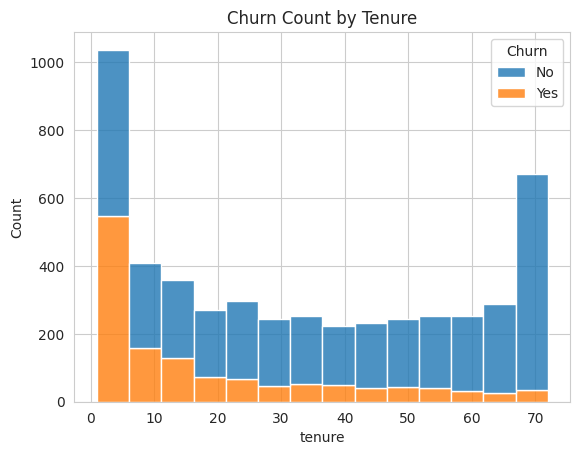

In [46]:
sns.histplot(x='tenure', hue='Churn', data=Data_All, bins=14, alpha=0.8, multiple='stack')
plt.title('Churn Count by Tenure')
plt.show()

Correlation coefficient: -0.19462794572065178
P-value: 3.6678433707785913e-44


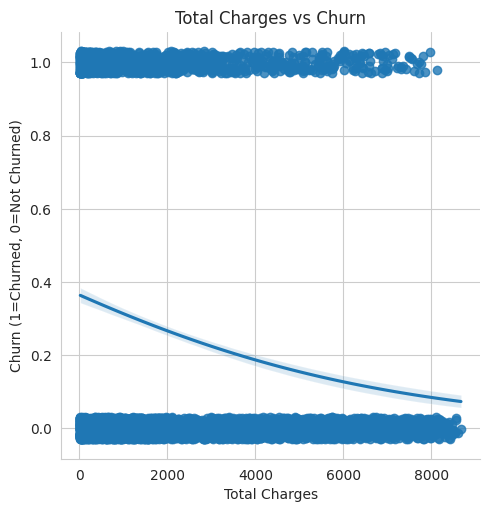

In [47]:
df_temp = df_hypo

# Convert "TotalCharges" column to numeric type and then to integers
df_temp["TotalCharges"] = pd.to_numeric(df_temp["TotalCharges"], errors="coerce", downcast="integer")

# Calculate the point-biserial correlation between TotalCharges and Churn
corr, p_value = pointbiserialr(df_temp["TotalCharges"], df_temp["Churn"])

# Print the correlation coefficient and p-value
print("Correlation coefficient:", corr)
print("P-value:", p_value)

# Plot the data points and visualize the relationship between TotalCharges and Churn
# logistic regression for binary dependent variable (Churn)

sns.lmplot(data=df_temp, x="TotalCharges", y="Churn", logistic=True, y_jitter=.03)
plt.xlabel("Total Charges")
plt.ylabel("Churn (1=Churned, 0=Not Churned)")
plt.title("Total Charges vs Churn")
plt.show()

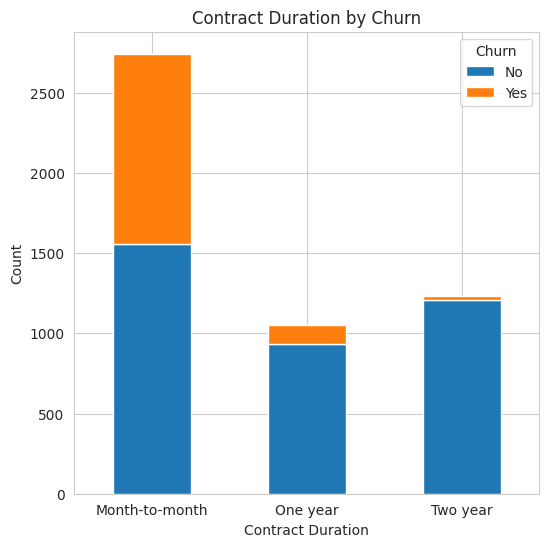

In [48]:
cross_tab = pd.crosstab(Data_All['Contract'], Data_All['Churn'])
ax = cross_tab.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Contract Duration by Churn")
plt.xlabel("Contract Duration")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.legend(title="Churn", loc="upper right")
plt.show()

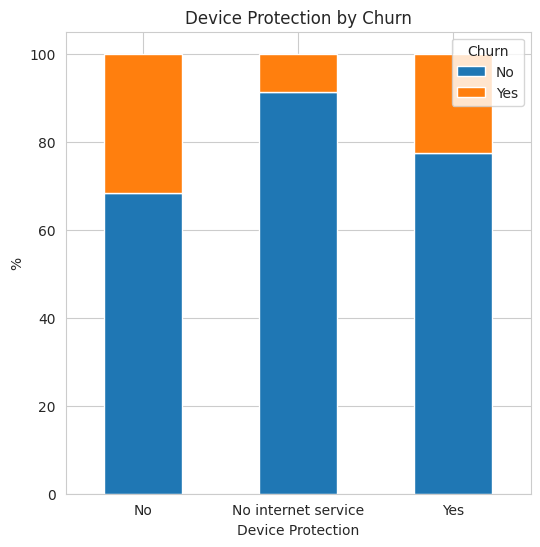

In [49]:
cross_tab = pd.crosstab(Data_All['DeviceProtection'], Data_All['Churn'])
percentages = cross_tab.div(cross_tab.sum(1), axis=0) * 100
ax = percentages.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Device Protection by Churn")
plt.xlabel("Device Protection")
plt.xticks(rotation=0)
plt.ylabel("%")
plt.legend(title="Churn", loc="upper right")
plt.show()

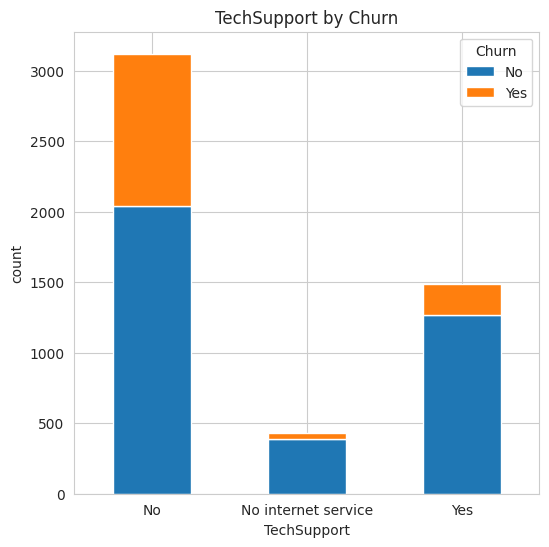

In [50]:
cross_tab = pd.crosstab(Data_All['TechSupport'], Data_All['Churn'])
ax = cross_tab.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("TechSupport by Churn")
plt.xlabel("TechSupport")
plt.xticks(rotation=0)
plt.ylabel("count")
plt.legend(title="Churn", loc="upper right")
plt.show()

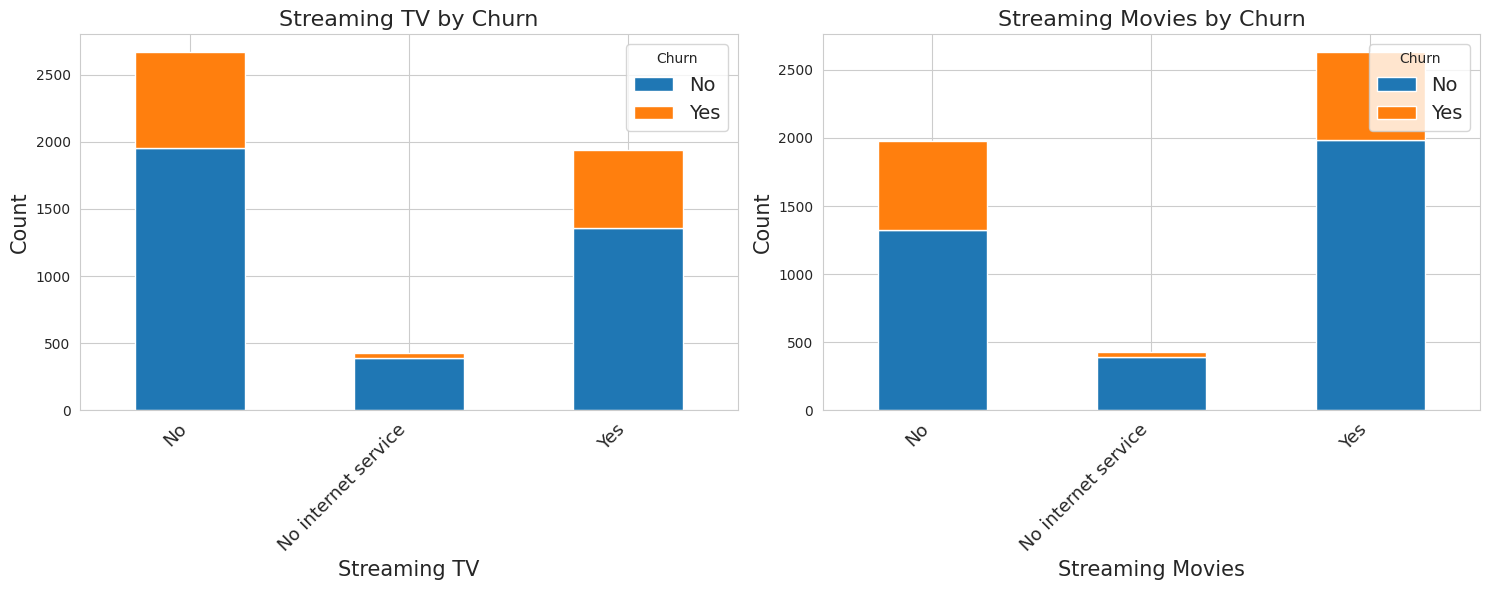

In [51]:
cross_tab1 = pd.crosstab(Data_All['StreamingTV'], Data_All['Churn'])
cross_tab2 = pd.crosstab(Data_All['StreamingMovies'], Data_All['Churn'])
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
cross_tab1.plot(kind="bar", stacked=True, ax=axes[0])
axes[0].set_title("Streaming TV by Churn", fontsize=16)
axes[0].set_xlabel("Streaming TV", fontsize=15)
axes[0].set_ylabel("Count", fontsize=15)
axes[0].legend(title="Churn", loc="upper right", fontsize=14)

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=13)
cross_tab2.plot(kind="bar", stacked=True, ax=axes[1])
axes[1].set_title("Streaming Movies by Churn", fontsize=16)
axes[1].set_xlabel("Streaming Movies",fontsize=15)
axes[1].set_ylabel("Count", fontsize=15)
axes[1].legend(title="Churn", loc="upper right", fontsize=14)

axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=13)
plt.tight_layout()
plt.show()

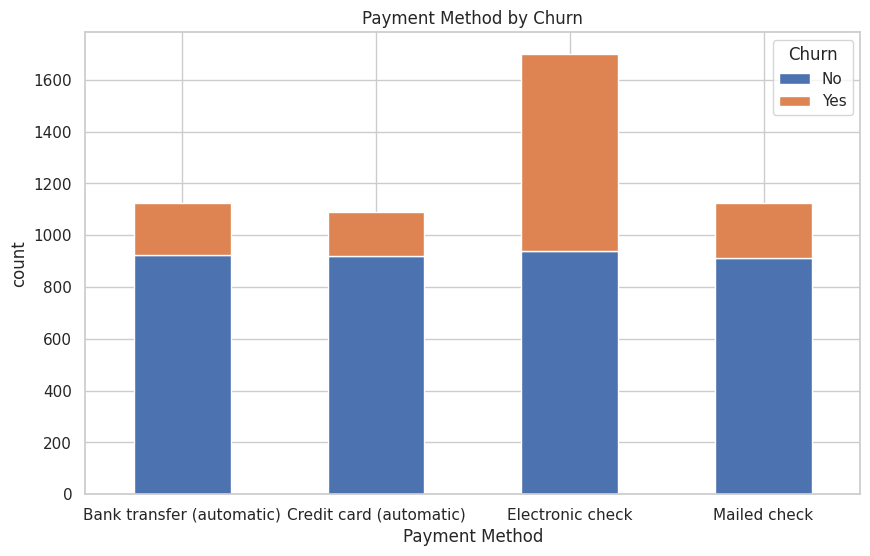

In [52]:
cross_tab = pd.crosstab(Data_All['PaymentMethod'], Data_All['Churn'])
sns.set(style="whitegrid")
ax = cross_tab.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Payment Method by Churn")
plt.xlabel("Payment Method")
plt.xticks(rotation=0)
plt.ylabel("count")
plt.legend(title="Churn", loc="upper right")
plt.show()

In [53]:
numeric_columns = df_hypo.select_dtypes(include=['int64', 'float64'])
numeric_columns.corr()

,tenure,MonthlyCharges,TotalCharges,Churn
tenure,1.000000,0.239642,0.826188,-0.352634
MonthlyCharges,0.239642,1.000000,0.646813,0.201995
TotalCharges,0.826188,0.646813,1.000000,-0.194628
Churn,-0.352634,0.201995,-0.194628,1.000000


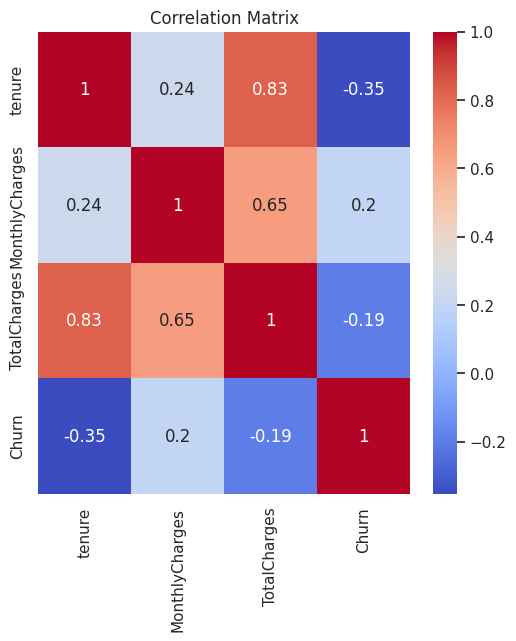

In [54]:
plt.figure(figsize=(6,6))
sns.heatmap(numeric_columns.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Processing & **Engineering**

In [55]:
Data_All.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5034 non-null   object 
 1   SeniorCitizen     5034 non-null   object 
 2   Partner           5034 non-null   object 
 3   Dependents        5034 non-null   object 
 4   tenure            5034 non-null   int64  
 5   PhoneService      5034 non-null   object 
 6   MultipleLines     5034 non-null   object 
 7   InternetService   5034 non-null   object 
 8   OnlineSecurity    5034 non-null   object 
 9   OnlineBackup      5034 non-null   object 
 10  DeviceProtection  5034 non-null   object 
 11  TechSupport       5034 non-null   object 
 12  StreamingTV       5034 non-null   object 
 13  StreamingMovies   5034 non-null   object 
 14  Contract          5034 non-null   object 
 15  PaperlessBilling  5034 non-null   object 
 16  PaymentMethod     5034 non-null   object 


In [56]:
x_cat = Data_All.select_dtypes(include=object).drop('Churn', axis=1)
y_cat = Data_All['Churn']

mi_scores = []
for column in x_cat.columns:
    mi_score = mutual_info_score(x_cat[column], y_cat)
    mi_scores.append((column, mi_score))

mi_scores.sort(key=lambda x: x[1], reverse=True)

for feature, score in mi_scores:
    print(f"{feature} - {score}")

Contract - 0.10284790516675524
InternetService - 0.05944428811167132
PaymentMethod - 0.04163984913943765
TechSupport - 0.030007109249305178
OnlineSecurity - 0.029670157336360276
PaperlessBilling - 0.019508874345666505
OnlineBackup - 0.015826778687180174
Dependents - 0.015615368107435551
DeviceProtection - 0.013717699147021103
StreamingMovies - 0.013349078621584257
SeniorCitizen - 0.010389723457655958
Partner - 0.010018147440621322
StreamingTV - 0.009953736504141789
MultipleLines - 0.0008281912846177519
PhoneService - 0.00010045042468448395
gender - 3.2190163546386152e-06


In [57]:
features = [score[0] for score in mi_scores]
scores = [score[1] for score in mi_scores]
fig = px.bar(x=scores, y=features, orientation='h', color=scores,
             labels={'x': 'Mutual Information Score', 'y': 'Features'},
             title='Categorical Features Relationship with Target (Churn)',
             template='plotly_dark',
             color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [58]:
Data_All.drop(columns=['gender','PhoneService', 'MultipleLines'], inplace=True)
df_encode = Data_All.copy()

### **Splitimg**

In [59]:
X = df_encode.drop(columns=['Churn'])
y = df_encode['Churn']

### **Label Encoding**

In [60]:
labelEncoder = LabelEncoder()

y = labelEncoder.fit_transform(y)

In [61]:
(X.shape, y.shape)

((5034, 16), (5034,))

### One-Hot **Encoding**

In [68]:
categorical_columns = ['SeniorCitizen', 'Partner', 'Dependents',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaperlessBilling','PaymentMethod']

transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), categorical_columns)
)

transformed_data = transformer.fit_transform(X[categorical_columns])

transformed_df = pd.DataFrame(transformed_data, columns=transformer.get_feature_names_out())

transformed_df.index = X.index

encoded_df = pd.concat([X, transformed_df], axis=1)

encoded_df.drop(categorical_columns, axis=1, inplace=True)

transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), categorical_columns)
)

transformed_data = transformer.fit_transform(X[categorical_columns])

transformed_df = pd.DataFrame(transformed_data, columns=transformer.get_feature_names_out())

transformed_df.index = X.index

encoded_df = pd.concat([X, transformed_df], axis=1)

encoded_df.drop(categorical_columns, axis=1, inplace=True)

In [69]:
encoded_df.head()

,tenure,MonthlyCharges,TotalCharges,onehotencoder__SeniorCitizen_No,onehotencoder__SeniorCitizen_Yes,onehotencoder__Partner_No,onehotencoder__Partner_Yes,onehotencoder__Dependents_No,onehotencoder__Dependents_Yes,onehotencoder__InternetService_DSL,onehotencoder__InternetService_Fiber optic,onehotencoder__InternetService_No,onehotencoder__OnlineSecurity_No,onehotencoder__OnlineSecurity_No internet service,onehotencoder__OnlineSecurity_Yes,onehotencoder__OnlineBackup_No,onehotencoder__OnlineBackup_No internet service,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_No,onehotencoder__DeviceProtection_No internet service,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_No,onehotencoder__TechSupport_No internet service,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_No,onehotencoder__StreamingTV_No internet service,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_No,onehotencoder__StreamingMovies_No internet service,onehotencoder__StreamingMovies_Yes,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaperlessBilling_No,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check
0,1,29.850000,29.850000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,34,56.950001,1889.500000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,53.849998,108.150002,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,45,42.299999,1840.750000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2,70.699997,151.649994,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [70]:
encoded_df.columns = encoded_df.columns.str.replace('onehotencoder__', '')
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   5034 non-null   int64  
 1   MonthlyCharges                           5034 non-null   float64
 2   TotalCharges                             5034 non-null   float64
 3   SeniorCitizen_No                         5034 non-null   float64
 4   SeniorCitizen_Yes                        5034 non-null   float64
 5   Partner_No                               5034 non-null   float64
 6   Partner_Yes                              5034 non-null   float64
 7   Dependents_No                            5034 non-null   float64
 8   Dependents_Yes                           5034 non-null   float64
 9   InternetService_DSL                      5034 non-null   float64
 10  InternetService_Fiber optic              5034 no

### **Features Scaling**

In [71]:
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
encoded_scaled = scaler.fit_transform(encoded_df[cols])
X_scaled_df = pd.DataFrame(encoded_scaled, columns=cols, index=X.index)
encoded_df.drop(cols, axis=1, inplace=True)
encoded_df = pd.concat([encoded_df, X_scaled_df], axis=1)

In [72]:
encoded_df.head()

,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.290184,-1.172700,-1.001315
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.056283,-0.271320,-0.181408
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.249382,-0.374430,-0.966794
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.505106,-0.758597,-0.202901
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.249382,0.186022,-0.947615


### **SMOTE (Synthetic Minority Over-sampling Technique)**

In [73]:
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(encoded_df, y)

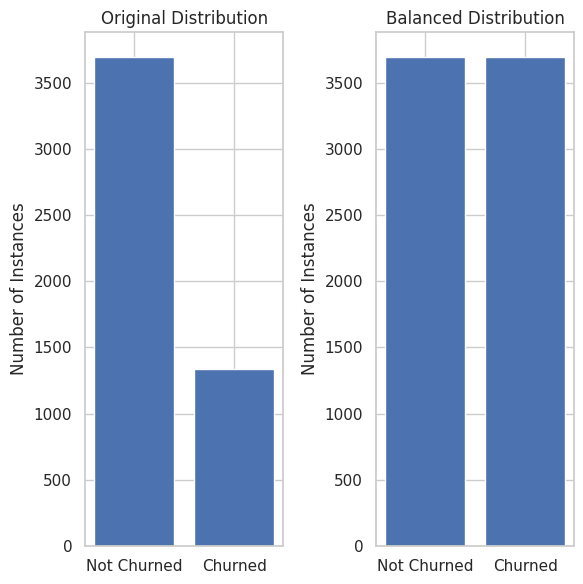

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(6, 6))
unique, counts = np.unique(y, return_counts=True)
axes[0].bar(unique, counts)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not Churned', 'Churned'])
axes[0].set_ylabel('Number of Instances')
axes[0].set_title('Original Distribution')
unique2, counts2 = np.unique(y_resampled, return_counts=True)
axes[1].bar(unique2, counts2)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Not Churned', 'Churned'])
axes[1].set_ylabel('Number of Instances')
axes[1].set_title('Balanced Distribution')
plt.tight_layout()
plt.show()

### **Train-test split**

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
pd.DataFrame(X_train).shape, pd.DataFrame(y_train).shape

((5916, 39), (5916, 1))

In [76]:
pd.value_counts(pd.Series(y_train))

,count
0,2958
1,2958


## **Model Building**

### **1. Logistic Regression Model**

In [77]:
LR = LogisticRegression(random_state=42)
LR.fit(X_train, y_train)

LogisticRegression(random_state=42)

### **2. K-nearest Neighbors(KNN)**

In [78]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

### **3. Random Forest**



In [79]:
rfm = RandomForestClassifier(random_state=42)
rfm.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### **4. Support Vector Machines Classifier(SVM)**

In [80]:
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

SVC(random_state=42)

### **5. Gradient Boosting**

In [81]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### **6. XGBoost**

In [82]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## **Model Evaluation**

### **K-Fold Cross-Validation**

In [84]:
models = [
    ('Logistic Regression', LR),
    ('K nearest neighbors', knn),
    ('Random Forest', rfm),
    ('SVC', svm),
    ('Gradient Boosting', gb),
    ('XGBoost', xgb)
]
k = 5

results = []

for name, model in models:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    results.append((name, scores.mean(), scores.std()))

results_df = pd.DataFrame(results, columns=['Model', 'Mean Accuracy', 'Std Deviation'])

results_df.sort_values(by='Mean Accuracy', ascending=False)

,Model,Mean Accuracy,Std Deviation
2,Random Forest,0.848884,0.006108
5,XGBoost,0.843982,0.009783
4,Gradient Boosting,0.839081,0.014148
3,SVC,0.806117,0.009330
1,K nearest neighbors,0.787186,0.009437
0,Logistic Regression,0.775690,0.013500


### **Classification Report**

In [85]:
model_names = ['Logistic Regression', 'k-NN', 'Random Forest', 'SVM', 'Gradient Boosting', 'XGBoost']
models = [LR, knn, rfm, svm, gb, xgb]
model_names_list = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, model in zip(model_names, models):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_names_list.append(name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

metrics_df = pd.DataFrame({
    'Model': model_names_list,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores
})
metrics_df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1-Score
2,Random Forest,0.856757,0.846457,0.871622,0.858855
5,XGBoost,0.851351,0.848525,0.855405,0.851952
4,Gradient Boosting,0.841216,0.823303,0.868919,0.845496
3,SVM,0.798649,0.779040,0.833784,0.805483
1,k-NN,0.790541,0.734205,0.910811,0.813028
0,Logistic Regression,0.777703,0.754647,0.822973,0.787330


In [86]:
metrics_df_sorted = metrics_df.sort_values(by='Accuracy')
fig = px.bar(metrics_df_sorted, x='Model', y='Accuracy', color='Model',
             title='Model Performance Metrics (Accuracy)',
             template='plotly_dark',
             labels={'Model': 'Model Name', 'Accuracy': 'Accuracy Score'}
            )
fig.show()

## **Hyperparameter tuning**

### **1. XGBoost**

In [87]:
current_params = xgb.get_params()
current_params

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [88]:
param_dist = {
    'n_estimators': [None, 50, 100, 500, 1000],
    'max_depth': [None, 3, 5, 7, 10],
    'min_child_weight': [None, 1, 2, 4, 6],
    'subsample': [None, 0.1, 0.2, 0.4, 0.6],
    'gamma': [None, 0, 0.1, 0.2, 0.3],
    'learning_rate': [None, 0.1, 0.2, 0.3],
    'reg_alpha': [None, 0, 0.1, 0.5, 1],
    'reg_lambda': [None, 0, 0.1, 0.5, 1],
}
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, scoring='accuracy',
                                     cv=5, n_jobs=-1, random_state=42, n_iter=150, verbose = 1)
random_search_xgb.fit(X_train, y_train)
best_params = random_search_xgb.best_params_
best_score = random_search_xgb.best_score_
best_params

Fitting 5 folds for each of 150 candidates, totalling 750 fits


{'subsample': None,
 'reg_lambda': 0,
 'reg_alpha': 1,
 'n_estimators': 50,
 'min_child_weight': None,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0}

In [89]:
best_score

np.float64(0.8539555299170685)

In [90]:
tuned_xgb_model = random_search_xgb.best_estimator_
tuned_xgb_model.fit(X_train, y_train)
random_search_xgb_pred = tuned_xgb_model.predict(X_test)
original_xgb_model = xgb.predict(X_test)

In [91]:
report = classification_report(y_test, original_xgb_model, output_dict=True)
report_2 = classification_report(y_test, random_search_xgb_pred, output_dict=True)
precision = ((report['1']['precision'] + report['0']['precision'])) / 2
recall = ((report['1']['recall'] + report['0']['recall'])) / 2
f1 = ((report['1']['f1-score'] + report['0']['f1-score'])) / 2

precision2 = ((report_2['1']['precision'] + report_2['0']['precision'])) / 2
recall2 = ((report_2['1']['recall'] + report_2['0']['recall'])) / 2
f12 = ((report_2['1']['f1-score'] + report_2['0']['f1-score'])) / 2


metrics_original_XGB = {
    'Total Precision': precision,
    'Total Recall': recall,
    'Total F1-Score': f1,
    'Accuracy': report['accuracy']
}

metrics_Tuned_XGB = {
    'Total Precision': precision2,
    'Total Recall': recall2,
    'Total F1-Score': f12,
    'Accuracy': report_2['accuracy']
}

metrics_df_original = pd.DataFrame(metrics_original_XGB, index=['Original XGBoost'])
metrics_df_xgb = pd.DataFrame(metrics_Tuned_XGB, index=['Tuned XGBoost'])
combined_metrics_df = pd.concat([metrics_df_original, metrics_df_xgb])

combined_metrics_df

,Total Precision,Total Recall,Total F1-Score,Accuracy
Original XGBoost,0.851374,0.851351,0.851349,0.851351
Tuned XGBoost,0.856488,0.856081,0.856040,0.856081


In [92]:
confusion_matrix_xgb = confusion_matrix(y_test, random_search_xgb_pred)
confusion_matrix_xgb

array([[621, 119],
       [ 94, 646]])

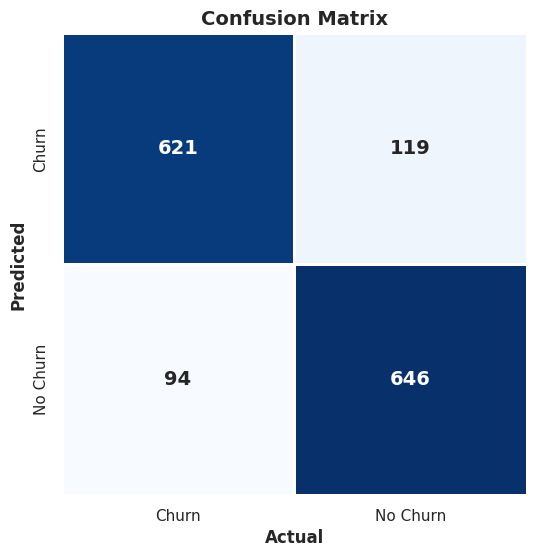

In [94]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14, "weight": 'bold'},
            xticklabels=['Churn', 'No Churn'],
            yticklabels=['Churn', 'No Churn'],
            linewidths=2, linecolor='white')
plt.xlabel('Actual', fontsize=12, fontweight='bold')
plt.ylabel('Predicted', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()


### **2. Random Forest**

In [95]:
current_params = rfm.get_params()
current_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [96]:
param_grid = {
  'n_estimators': [20, 50, 100, 200, 300],
  'max_depth': [None, 10, 15, 20, 25],
  'min_samples_split': [2, 3, 4, 5, 6],
  'min_samples_leaf': [1, 2, 3, 4, 5],
  'class_weight': ['balanced', None],
  'max_features': ['auto', 'sqrt', 'log2'],
  'criterion': ['gini', 'entropy']
}
random_search_rf = RandomizedSearchCV(estimator=rfm, param_distributions=param_grid,
                                      scoring='accuracy', n_iter=150, random_state=42,
                                      cv=5, n_jobs=-1, verbose = 1)

random_search_rf.fit(X_train, y_train)
best_params = random_search_rf.best_params_
best_score = random_search_rf.best_score_
best_params

Fitting 5 folds for each of 150 candidates, totalling 750 fits


{'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25,
 'criterion': 'gini',
 'class_weight': None}

In [97]:
best_score

np.float64(0.8497294155948001)

In [98]:
tuned_rf_model = random_search_rf.best_estimator_
tuned_rf_model.fit(X_train, y_train)
random_search_rf_pred = tuned_rf_model.predict(X_test)
original_rf_model = rfm.predict(X_test)

In [99]:
report = classification_report(y_test, original_rf_model, output_dict=True)
report_2 = classification_report(y_test, random_search_rf_pred, output_dict=True)
precision = ((report['1']['precision'] + report['0']['precision'])) / 2
recall = ((report['1']['recall'] + report['0']['recall'])) / 2
f1 = ((report['1']['f1-score'] + report['0']['f1-score'])) / 2

precision2 = ((report_2['1']['precision'] + report_2['0']['precision'])) / 2
recall2 = ((report_2['1']['recall'] + report_2['0']['recall'])) / 2
f12 = ((report_2['1']['f1-score'] + report_2['0']['f1-score'])) / 2

metrics_original_Random_Forest = {
    'Total Precision': precision,
    'Total Recall': recall,
    'Total F1-Score': f1,
    'Accuracy': report['accuracy']
}

metrics_Tuned_Random_Forest = {
    'Total Precision': precision2,
    'Total Recall': recall2,
    'Total F1-Score': f12,
    'Accuracy': report_2['accuracy']
}


metrics_df_original = pd.DataFrame(metrics_original_Random_Forest, index=['Original Random Forest'])
metrics_df_tuned = pd.DataFrame(metrics_Tuned_Random_Forest, index=['Tuned Random Forest'])

combined_metrics_df = pd.concat([metrics_df_original, metrics_df_tuned])

combined_metrics_df

,Total Precision,Total Recall,Total F1-Score,Accuracy
Original Random Forest,0.857072,0.856757,0.856725,0.856757
Tuned Random Forest,0.854264,0.854054,0.854032,0.854054


In [100]:

confusion_matrix_rf = confusion_matrix(y_test, random_search_rf_pred)

confusion_matrix_rf

array([[623, 117],
       [ 99, 641]])

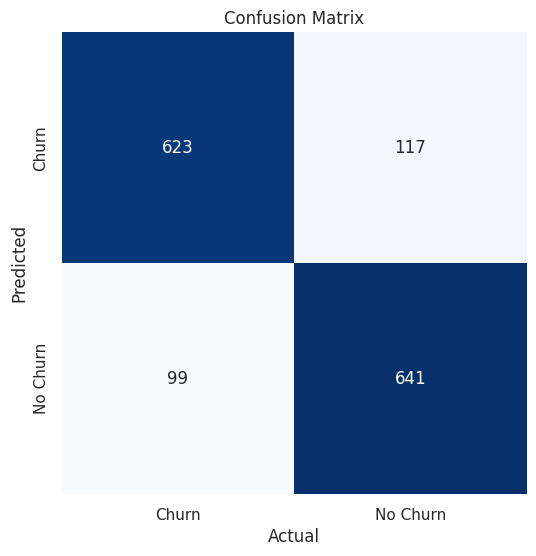

In [101]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Churn', 'No Churn'],
            yticklabels=['Churn', 'No Churn'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

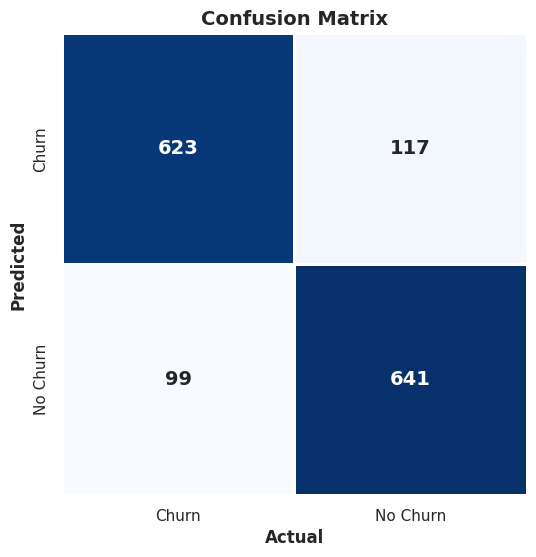

In [102]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14, "weight": 'bold'},
            xticklabels=['Churn', 'No Churn'],
            yticklabels=['Churn', 'No Churn'],
            linewidths=2, linecolor='white')
plt.xlabel('Actual', fontsize=12, fontweight='bold')
plt.ylabel('Predicted', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()

### **3. Gradient Boosting**

In [103]:

current_params = gb.get_params()
current_params

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [104]:
param_grid = {
    'n_estimators': [None, 50, 100, 200, 300],
    'learning_rate': [None, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [None, 3, 5, 7, 10],
    'subsample': [0.8, 0.9, 1.0, 1.1, 1.2],
    'min_samples_split': [2, 3, 5, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 8],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.1, 0.2]
}
random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=param_grid, scoring='accuracy',
                                      cv=5,n_jobs=-1, n_iter=150, random_state=42, verbose = 2)
random_search_gb.fit(X_train, y_train)
best_params = random_search_gb.best_params_
best_score = random_search_gb.best_score_
best_params

Fitting 5 folds for each of 150 candidates, totalling 750 fits


{'subsample': 0.8,
 'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'min_impurity_decrease': 0.0,
 'max_features': 'log2',
 'max_depth': 5,
 'learning_rate': 0.1,
 'criterion': 'friedman_mse',
 'ccp_alpha': 0.0}

In [105]:
best_score

np.float64(0.848714759772452)

In [106]:

tuned_gb_model = random_search_gb.best_estimator_
tuned_gb_model.fit(X_train, y_train)

random_search_gb_pred = tuned_gb_model.predict(X_test)
original_gb_model = gb.predict(X_test)

In [107]:
report = classification_report(y_test, original_gb_model, output_dict=True)
report_2 = classification_report(y_test, random_search_gb_pred, output_dict=True)

precision = ((report['1']['precision'] + report['0']['precision'])) / 2
recall = ((report['1']['recall'] + report['0']['recall'])) / 2
f1 = ((report['1']['f1-score'] + report['0']['f1-score'])) / 2

precision2 = ((report_2['1']['precision'] + report_2['0']['precision'])) / 2
recall2 = ((report_2['1']['recall'] + report_2['0']['recall'])) / 2
f12 = ((report_2['1']['f1-score'] + report_2['0']['f1-score'])) / 2


metrics_original_GB = {
    'Total Precision': precision,
    'Total Recall': recall,
    'Total F1-Score': f1,
    'Accuracy': report['accuracy']
}

metrics_Tuned_GB = {
    'Total Precision': precision2,
    'Total Recall': recall2,
    'Total F1-Score': f12,
    'Accuracy': report_2['accuracy']
}

metrics_df_original = pd.DataFrame(metrics_original_GB, index=['Original Gradient Boosting'])
metrics_df_gb = pd.DataFrame(metrics_Tuned_GB, index=['Tuned Gradient Boosting'])


combined_metrics_df = pd.concat([metrics_df_original, metrics_df_gb])

combined_metrics_df

,Total Precision,Total Recall,Total F1-Score,Accuracy
Original Gradient Boosting,0.842267,0.841216,0.841094,0.841216
Tuned Gradient Boosting,0.853139,0.852703,0.852657,0.852703


In [108]:
confusion_matrix_gb = confusion_matrix(y_test, random_search_gb_pred)
confusion_matrix_gb

array([[618, 122],
       [ 96, 644]])

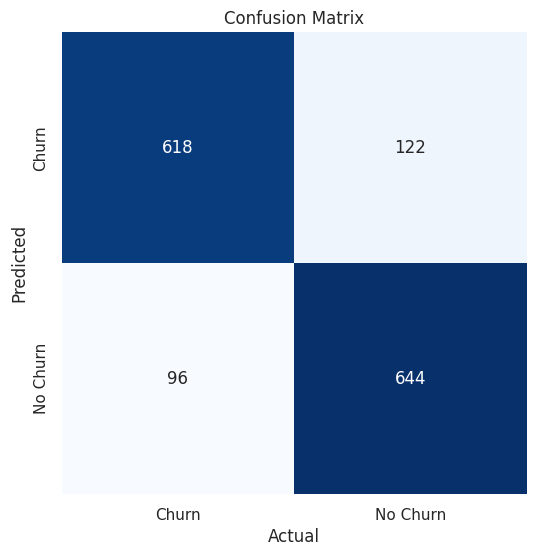

In [109]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Churn', 'No Churn'],
            yticklabels=['Churn', 'No Churn'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

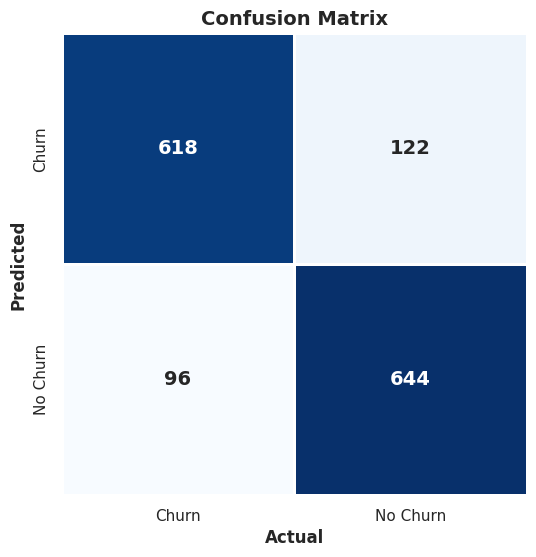

In [110]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14, "weight": 'bold'},
            xticklabels=['Churn', 'No Churn'],
            yticklabels=['Churn', 'No Churn'],
            linewidths=2, linecolor='white')
plt.xlabel('Actual', fontsize=12, fontweight='bold')
plt.ylabel('Predicted', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()

## **Model Saving**

In [111]:
import os
import joblib

destination = "Toolkit"
if not os.path.exists(destination):
    os.makedirs(destination)
models ={
    "random_forest_best_model":tuned_rf_model,
}
for name,model in models.items():
    file_path =os.path.join(destination,f"{name}.joblib")
    joblib.dump(model,file_path)

## **Future Predictions**


### **Preprocessing of test data**

In [112]:
test = pd.read_csv('Test_Data.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        1997 non-null   object 
 1   gender            1997 non-null   object 
 2   SeniorCitizen     1997 non-null   object 
 3   Partner           1997 non-null   object 
 4   Dependents        1997 non-null   object 
 5   tenure            1997 non-null   int64  
 6   PhoneService      1997 non-null   object 
 7   MultipleLines     1997 non-null   object 
 8   InternetService   1997 non-null   object 
 9   OnlineSecurity    1997 non-null   object 
 10  OnlineBackup      1997 non-null   object 
 11  DeviceProtection  1997 non-null   object 
 12  TechSupport       1997 non-null   object 
 13  StreamingTV       1997 non-null   object 
 14  StreamingMovies   1997 non-null   object 
 15  Contract          1997 non-null   object 
 16  PaperlessBilling  1997 non-null   object 


In [113]:
customerID = test['customerID']
test.drop(columns=['gender','PhoneService', 'MultipleLines', 'customerID'],axis = 1, inplace=True)

In [116]:
cat_cols = ['SeniorCitizen', 'Partner', 'Dependents',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod']

transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols))

transformed_data = transformer.fit_transform(test[cat_cols])
transformed_df = pd.DataFrame(transformed_data, columns=transformer.get_feature_names_out())
transformed_df.index = test.index
test = pd.concat([test, transformed_df], axis=1)
test.drop(cat_cols, axis=1, inplace=True)
test.head()


,tenure,MonthlyCharges,TotalCharges,onehotencoder__SeniorCitizen_No,onehotencoder__SeniorCitizen_Yes,onehotencoder__Partner_No,onehotencoder__Partner_Yes,onehotencoder__Dependents_No,onehotencoder__Dependents_Yes,onehotencoder__InternetService_DSL,onehotencoder__InternetService_Fiber optic,onehotencoder__InternetService_No,onehotencoder__OnlineSecurity_No,onehotencoder__OnlineSecurity_No internet service,onehotencoder__OnlineSecurity_Yes,onehotencoder__OnlineBackup_No,onehotencoder__OnlineBackup_No internet service,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_No,onehotencoder__DeviceProtection_No internet service,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_No,onehotencoder__TechSupport_No internet service,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_No,onehotencoder__StreamingTV_No internet service,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_No,onehotencoder__StreamingMovies_No internet service,onehotencoder__StreamingMovies_Yes,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaperlessBilling_No,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check
0,12,84.45,1059.55,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,9,20.40,181.80,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,27,81.70,2212.55,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,27,79.50,2180.55,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1,89.15,89.15,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [117]:
test.columns =test.columns.str.replace('onehotencoder__', '')

In [118]:
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test[cols])
test_scaled_df = pd.DataFrame(test_scaled, columns=cols, index=test.index)
test.drop(cols, axis=1, inplace=True)
test = pd.concat([test, test_scaled_df], axis=1)
test.head()

,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.808517,0.679346,-0.520729
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.930399,-1.448044,-0.909246
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.199108,0.588006,-0.010377
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.199108,0.514934,-0.024542
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.255417,0.835454,-0.950256


### **Predictions**

In [119]:
import joblib
loaded_model = joblib.load('/content/Toolkit/random_forest_best_model.joblib')
predictions = loaded_model.predict(test)
predictions_df = pd.DataFrame(predictions, columns=['Predicted_Label'])
predictions_df['customer_id'] = customerID.reset_index(drop=True)
predictions_df.set_index('customer_id', inplace=True)
predictions_df.head()

,Predicted_Label
customer_id,
7613-LLQFO,1
4568-TTZRT,0
9513-DXHDA,0
2640-PMGFL,0
3801-HMYNL,1


In [120]:
predictions_df['Predicted_Label'] = predictions_df['Predicted_Label'].map({0: 'No', 1: 'Yes'})
predictions_df.value_counts()

,count
Predicted_Label,
No,1413
Yes,584


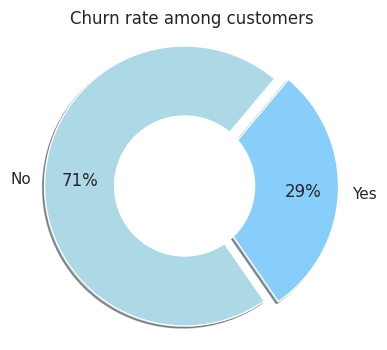

In [121]:
label_counts = predictions_df['Predicted_Label'].value_counts()
count_values = label_counts.values
plt.figure(figsize=(4, 4))
plt.pie(count_values, labels=label_counts.index, colors=['LightBlue','LightSkyBlue'], startangle=50, shadow=True, radius=2,
     explode=(0,0.2),autopct='%1.0f%%', pctdistance=0.75 ,  )
Circle=plt.Circle((0,0), 1, color='white')
c= plt.gcf()
c.gca().add_artist(Circle)
plt.axis('equal')
plt.title('Churn rate among customers')
plt.show()

In [122]:
y_pred_loaded = loaded_model.predict(test)
print("✅ Predictions:", y_pred_loaded[:10])

✅ Predictions: [1 0 0 0 1 0 1 1 0 0]


#**Conclusion**
This project leveraged machine learning techniques to predict customer churn in the telecommunications industry. By conducting exploratory data analysis, feature engineering, and model evaluation, we identified crucial factors impacting churn, such as contract type, tenure, and monthly charges.

With an 80/20 train-eval split, the Random Forest model achieved an accuracy of approximately 85-86% after hyperparameter tuning, making it the best-performing model compared to alternatives like Logistic Regression and Decision Trees. The analysis highlighted that customers with short tenure and month-to-month contracts are more prone to churn, while those with long-term contracts tend to remain loyal.

#**Key Takeaways:**



Tenure and contract type strongly influence churn probability.

1. Tenure and contract type strongly influence churn probability.
3. Early-stage customers (5–10 months) have a higher risk of leaving.
4. Random Forest outperformed other models with an 86% accuracy after tuning.

5. Encouraging long-term contracts and enhancing customer onboarding can help reduce churn.



#**Future Scope:**
1. Integrating deep learning models for more precise predictions.

2. Deploying real-time churn prediction systems for proactive retention.

3. Customer segmentation to personalize offers and improve engagement.

This study provides actionable insights for telecom companies to enhance customer retention strategies, optimize marketing efforts, and drive sustainable business growth.